---
title: Comparing the predicted reference epigenome to Enformer runs centered at the TSS and ground truth
author: Sabrina Mi
date: 8/28/2023
---

We are trying to debug low correlation values between predicted reference CAGE values and reference observed gene expression by inspecting a few genes.

## Select Genes

In [ ]:
#| output: false
import tensorflow as tf
# Make sure the GPU is enabled 
assert tf.config.list_physical_devices('GPU'), 'Start the colab kernel with GPU: Runtime -> Change runtime type -> GPU'
import tensorflow_hub as hub
import joblib
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

transform_path = 'gs://dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'
model_path = 'https://tfhub.dev/deepmind/enformer/1'
fasta_file = '/home/s1mi/enformer_rat_data/reference_genome/hg38_genome.fasta'

In [28]:
annot_df = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/hg38.protein_coding_TSS.txt", sep="\t")
genes = annot_df.sample(n=10)

## Run Enformer at the TSS

In [17]:
#| code-fold: true
SEQUENCE_LENGTH = 393216

class Enformer:

  def __init__(self, tfhub_url):
    self._model = hub.load(tfhub_url).model

  def predict_on_batch(self, inputs):
    predictions = self._model.predict_on_batch(inputs)
    return {k: v.numpy() for k, v in predictions.items()}

  @tf.function
  def contribution_input_grad(self, input_sequence,
                              target_mask, output_head='human'):
    input_sequence = input_sequence[tf.newaxis]

    target_mask_mass = tf.reduce_sum(target_mask)
    with tf.GradientTape() as tape:
      tape.watch(input_sequence)
      prediction = tf.reduce_sum(
          target_mask[tf.newaxis] *
          self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

    input_grad = tape.gradient(prediction, input_sequence) * input_sequence
    input_grad = tf.squeeze(input_grad, axis=0)
    return tf.reduce_sum(input_grad, axis=-1)
  
def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()
  
class FastaStringExtractor:
    
    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()
    
def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)


In [4]:
model = Enformer(model_path)
fasta_extractor = FastaStringExtractor(fasta_file)

In [5]:
## Create Interval object for each TSS
intervals = [kipoiseq.Interval('chr'+ row['chromosome_name'], row['transcription_start_site'], row['transcription_start_site'])
            for _, row in genes.iterrows()]

In [11]:
tss_predictions = {}
for index, gene in enumerate(genes['ensembl_gene_id']):
    tss = intervals[index]
    sequence_one_hot = one_hot_encode(fasta_extractor.extract(tss.resize(SEQUENCE_LENGTH)))
    tss_predictions[gene] = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

## Query Predicted Reference Epigenome at the TSS

In [15]:
#| code-fold: true
import h5py

enfref_dir = "/grand/TFXcan/imlab/users/lvairus/reftile_project/enformer-reference-epigenome"

def query_epigenome(chr_num, center_bp, num_bins=3, tracks=-1):
    """
    Parameters:
        path_to_enfref (str): path to the directory containing the concatenated reference enformer files
        chr_num (int/string): chromosome number
        center_bp (int): center base pair position (1-indexed)
        num_bins (int): number of bins to extract centered around center_bp (default: 896) 
            note: if the number of bins is even, the center bin will be in the second half of the array
        tracks (int list): list of tracks to extract (default: all 5313 tracks)

    Returns:
        epigen (np.array): enformer predictions centered at center_bp of shape (num_bins, len(tracks))
    """

    # from position choose center bin
    center_ind = center_bp - 1
    center_bin = center_ind // 128
    
    half_bins = num_bins // 2
    start_bin = center_bin - half_bins
    end_bin = center_bin + half_bins
    if num_bins % 2 != 0: # if num_bins is odd
        end_bin += 1

    with h5py.File(f"{enfref_dir}/chr{chr_num}_cat.h5", "r") as f:
        # get tracks if list provided
        if tracks == -1:
            epigen = f[f'chr{chr_num}'][start_bin:end_bin, :] 
        else:
            epigen = f[f'chr{chr_num}'][start_bin:end_bin, tracks] 

    return epigen

In [17]:
predicted_reference_epigenome = {}
for index, gene in enumerate(genes['ensembl_gene_id']):
    chr = genes.iloc[index]['chromosome_name']
    pos = genes.iloc[index]['transcription_start_site']
    predicted_reference_epigenome[gene] = query_epigenome(chr, pos, num_bins=896)

We'll save these matrices so we can come back to the same genes.

In [19]:
# with h5py.File('/home/s1mi/enformer_rat_data/output/hg38_tss_predictions.h5', 'w') as hf:
#     for key, value in tss_predictions.items():
#         hf[key] = value
# with h5py.File('/home/s1mi/enformer_rat_data/output/hg38_reference_epigenome_tss.h5', 'w') as hf:
#     for key, value in predicted_reference_epigenome.items():
#         hf[key] = value

In [7]:
import h5py
import kipoiseq
from kipoiseq import Interval
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

annot_df = pd.read_csv("/home/s1mi/enformer_rat_data/annotation/hg38.protein_coding_TSS.txt", sep="\t", index_col='ensembl_gene_id')


In [4]:
predicted_reference_epigenome = {}
with h5py.File('/home/s1mi/enformer_rat_data/output/hg38_reference_epigenome_tss.h5', 'r') as hf:
    for key in hf.keys():
        predicted_reference_epigenome[key] = hf[key][()]
tss_predictions = {}
with h5py.File('/home/s1mi/enformer_rat_data/output/hg38_tss_predictions.h5', 'r') as hf:
    for key in hf.keys():
        tss_predictions[key] = hf[key][()]


## Compare Matrices

I used Laura's matrix comparison functions, which can be expanded below:

In [11]:
#| code-fold: true
def get_diffmat(mat1, mat2):
    
    diffmat = mat1 - mat2
    colwise_maxes1 = np.max(mat1, axis=0)
    colwise_maxes2 = np.max(mat2, axis=0)

    colwise_maxes_maxes = np.maximum(colwise_maxes1, colwise_maxes2)

    relmax3_diffmat = diffmat / colwise_maxes_maxes
    relmax3_diffmat = np.abs(relmax3_diffmat)
    return relmax3_diffmat

def get_summary(arr):
    summary = {
        "mean": np.mean(arr),
        "median": np.median(arr),
        "minimum": np.min(arr),
        "maximum": np.max(arr),
        "q1": np.percentile(arr, 25),
        "q3": np.percentile(arr, 75),
    }
    return summary

def plot_hist(arr, bin_num, xlab='Value', ylab='Frequency', title='Histogram'):
    plt.hist(arr, bins=bin_num)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

In [23]:
diff_mats = {gene: get_diffmat(tss_predictions[gene], predicted_reference_epigenome[gene]) for gene in tss_predictions.keys()}
for gene in diff_mats.keys():
    print(gene, "summary:\n", get_summary(diff_mats[gene]))


ENSG00000014257 summary:
 {'mean': 0.10938877, 'median': 0.04974805, 'minimum': 0.0, 'maximum': 1.0, 'q1': 0.010111116105690598, 'q3': 0.1516108550131321}
ENSG00000047457 summary:
 {'mean': 0.08590854, 'median': 0.03547225, 'minimum': 0.0, 'maximum': 0.99996144, 'q1': 0.007081934134475887, 'q3': 0.11259441636502743}
ENSG00000070193 summary:
 {'mean': 0.026367702, 'median': 0.010873516, 'minimum': 0.0, 'maximum': 0.985605, 'q1': 0.002833168429788202, 'q3': 0.031836215406656265}
ENSG00000085999 summary:
 {'mean': 0.07470728, 'median': 0.021258086, 'minimum': 0.0, 'maximum': 0.99999213, 'q1': 0.0033360121306031942, 'q3': 0.08667697757482529}
ENSG00000116685 summary:
 {'mean': 0.08169045, 'median': 0.022225916, 'minimum': 2.8047395e-10, 'maximum': 0.999989, 'q1': 0.003913101390935481, 'q3': 0.09082910791039467}
ENSG00000117724 summary:
 {'mean': 0.074016586, 'median': 0.02301056, 'minimum': 9.380969e-10, 'maximum': 0.99999017, 'q1': 0.003953242674469948, 'q3': 0.08899018913507462}
ENSG0000

Since `get_diffmat` quantifies relative difference between two matrices, a maximum  of 1 is quite high. 

In [24]:
corr_dict = {key: np.empty(5313) for key in diff_mats.keys()}
for gene in corr_dict.keys():
    for col in range(5313):
        col_corr = np.corrcoef(tss_predictions[gene][:, col], predicted_reference_epigenome[gene][:, col])[0, 1]
        corr_dict[gene][col] = col_corr

{'mean': -0.04785147985005888, 'median': -0.04247129995058821, 'minimum': -0.393485921068072, 'maximum': 0.509981085543981, 'q1': -0.09057495943261885, 'q3': -0.003294211203314511}


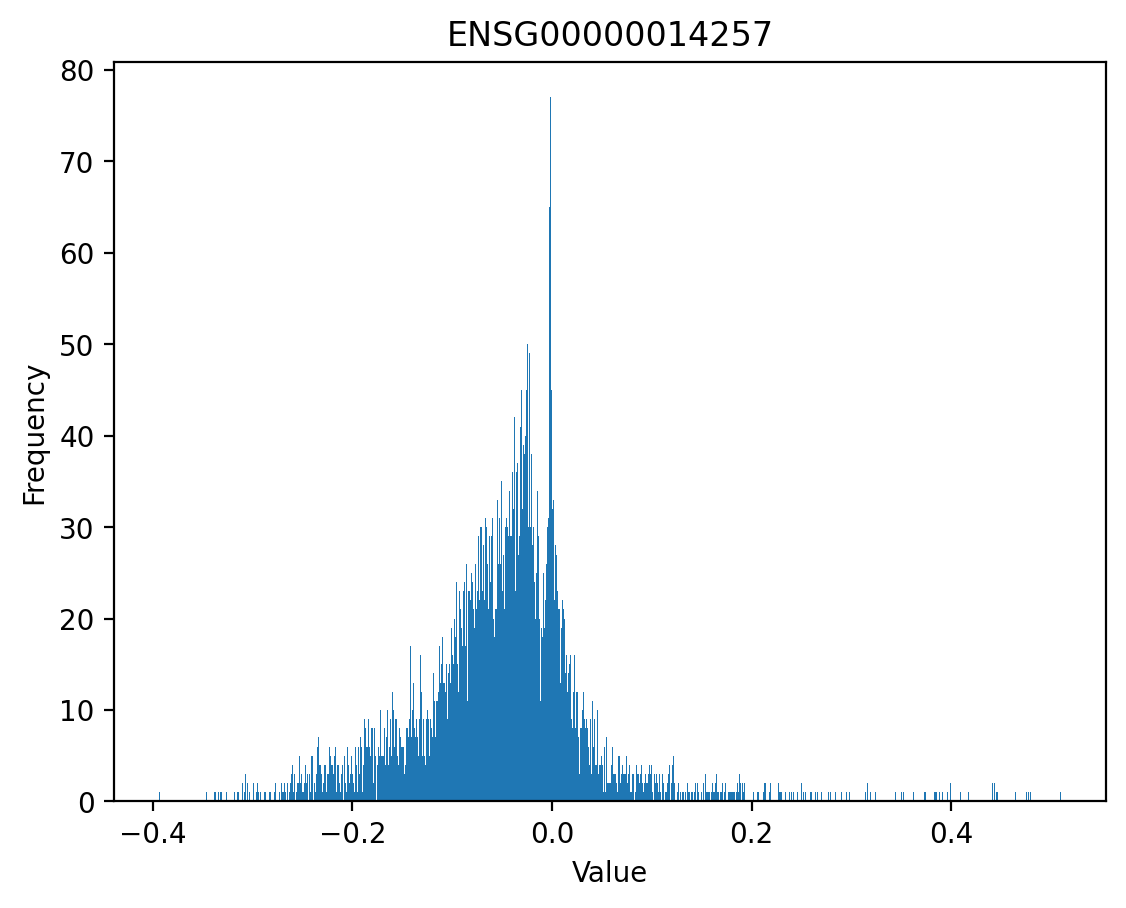

{'mean': -0.020498366469399766, 'median': -0.01635452627300118, 'minimum': -0.6671151615187328, 'maximum': 0.46799106943995916, 'q1': -0.06370733918391472, 'q3': 0.007784694436122131}


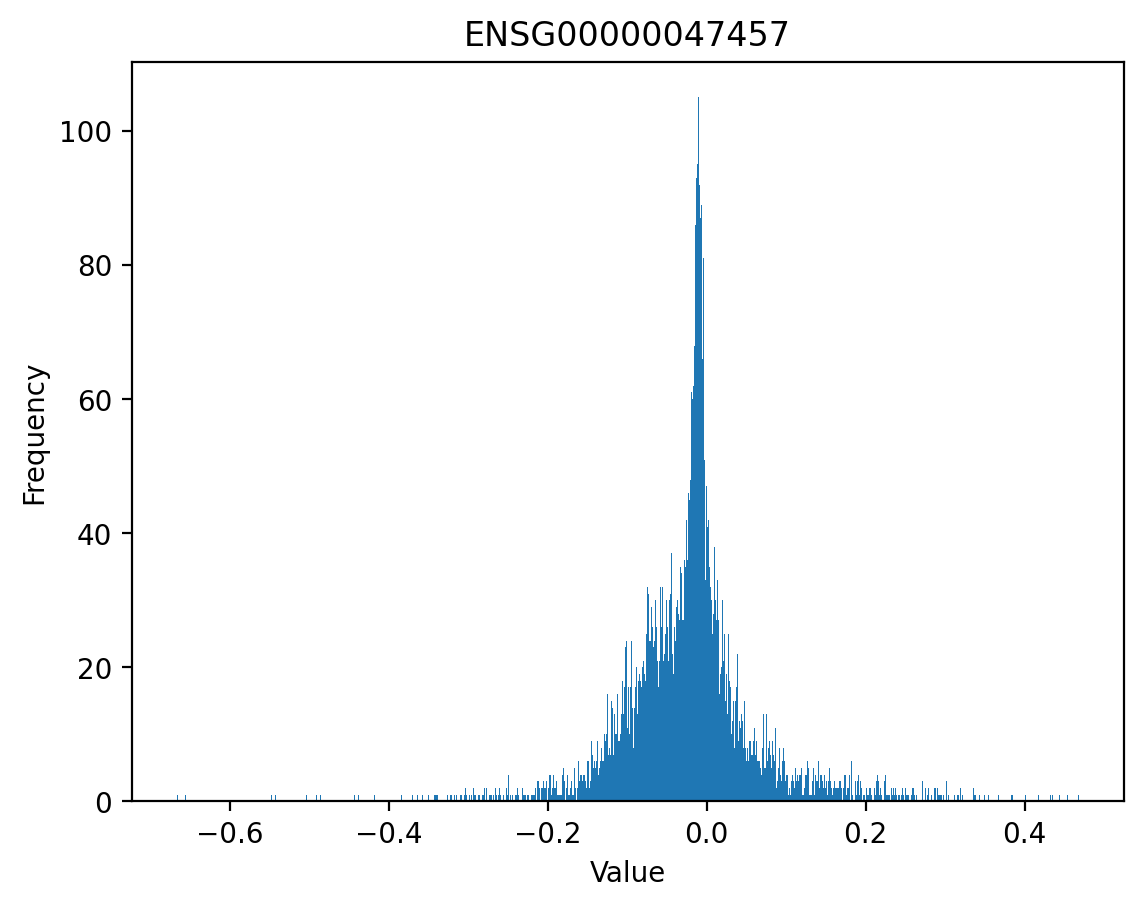

{'mean': 0.8845764960574595, 'median': 0.905038587998292, 'minimum': 0.29442496971600535, 'maximum': 0.9900524290440801, 'q1': 0.8661030004594839, 'q3': 0.9431178097172073}


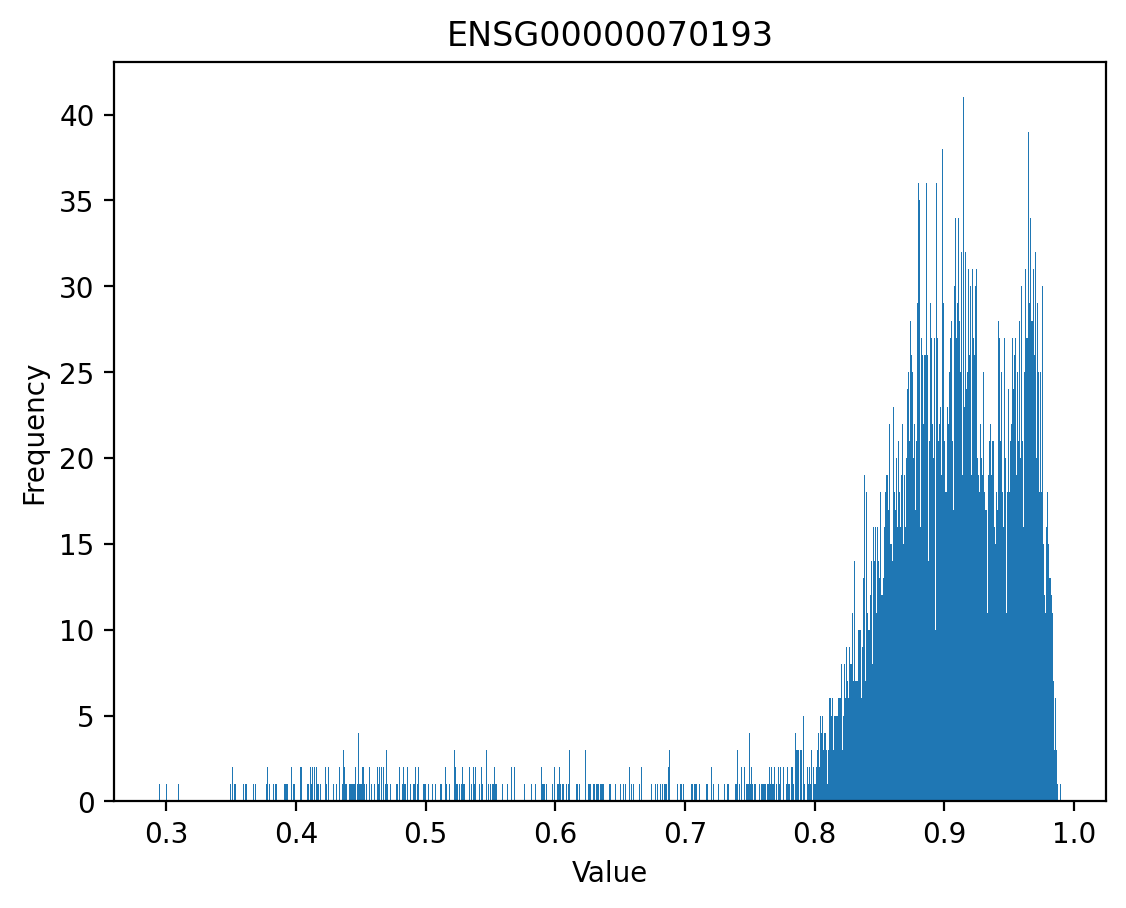

{'mean': -0.004693486538049062, 'median': -0.023538338438319352, 'minimum': -0.21624727795007467, 'maximum': 0.5926171533980982, 'q1': -0.04864174469821785, 'q3': -0.0025296129930357956}


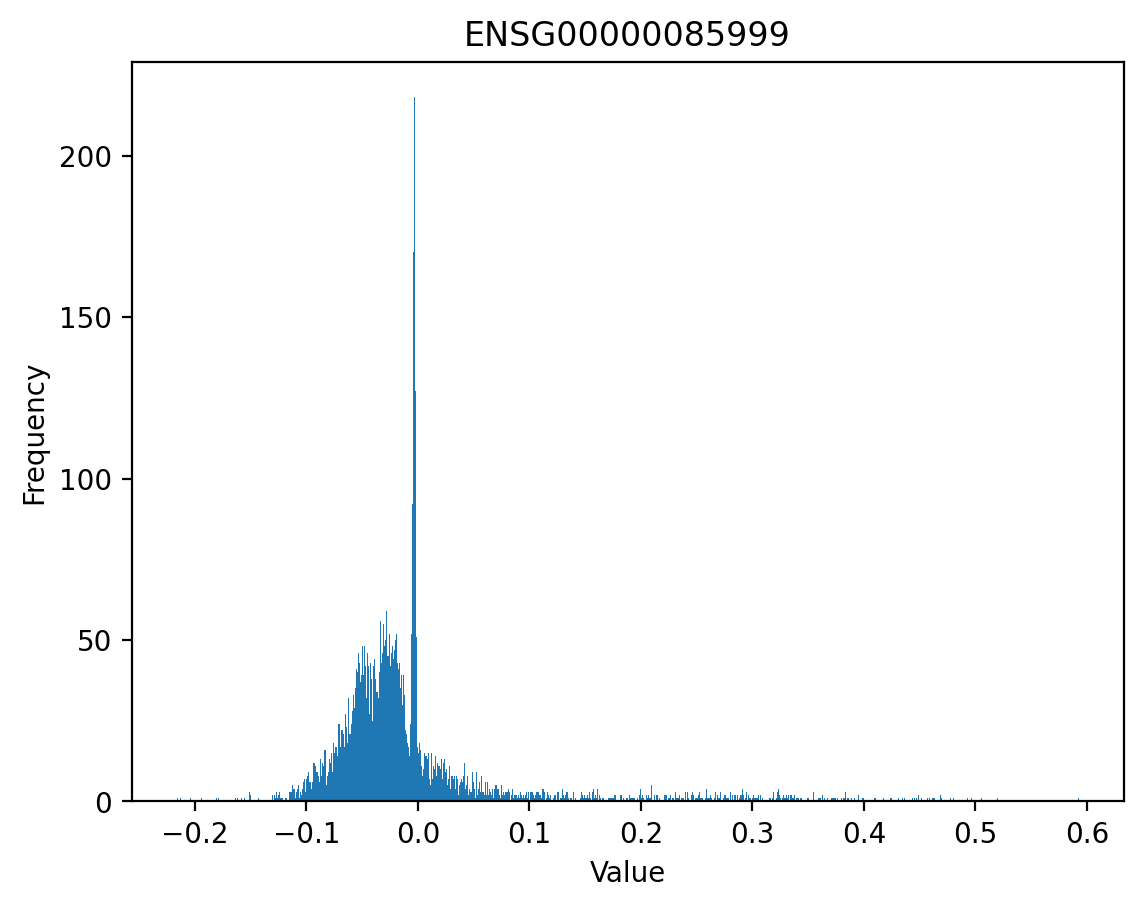

{'mean': -0.04003020470988491, 'median': -0.0165219043540768, 'minimum': -0.5986776492089833, 'maximum': 0.31508676003094743, 'q1': -0.037667550234998355, 'q3': -0.0002014276916713896}


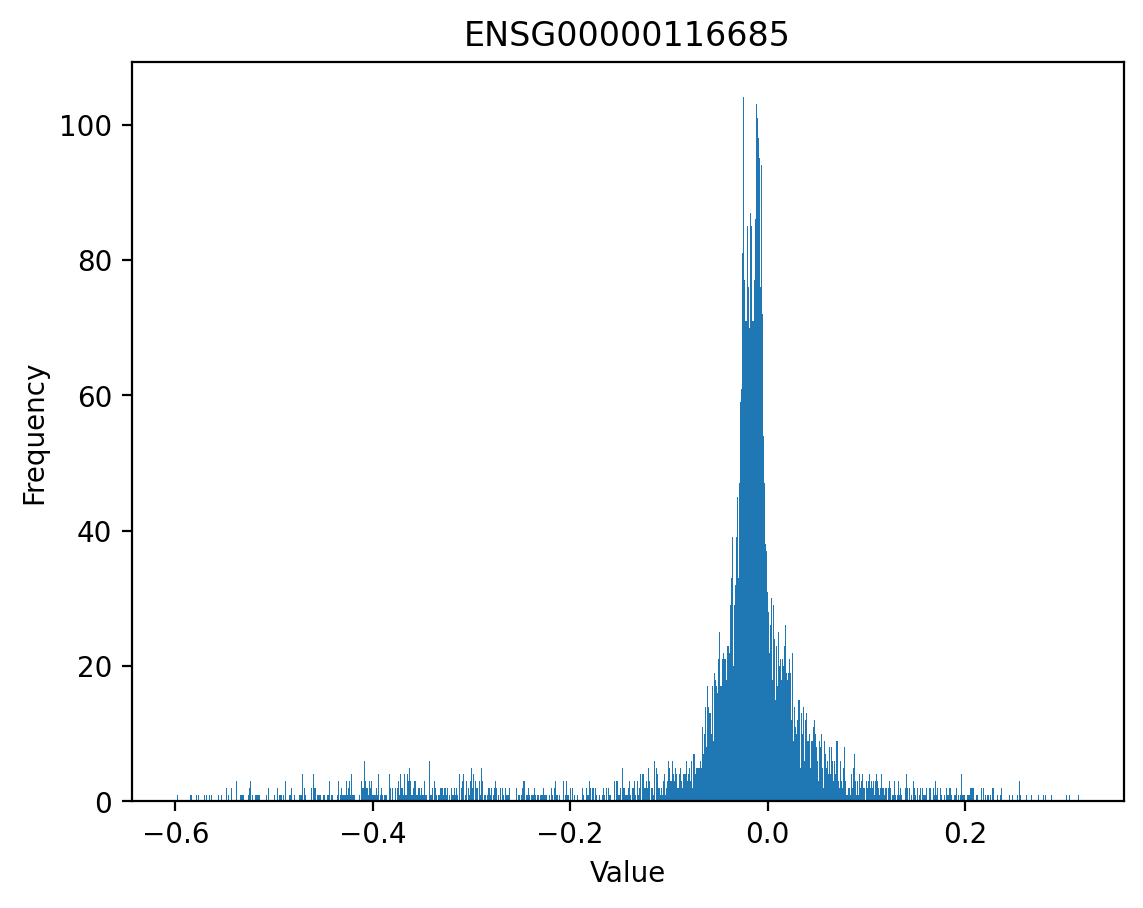

{'mean': 0.00018114387424161856, 'median': 0.0026720968249750016, 'minimum': -0.5204256293106989, 'maximum': 0.4990381262855727, 'q1': -0.018076527923798567, 'q3': 0.03691570827431883}


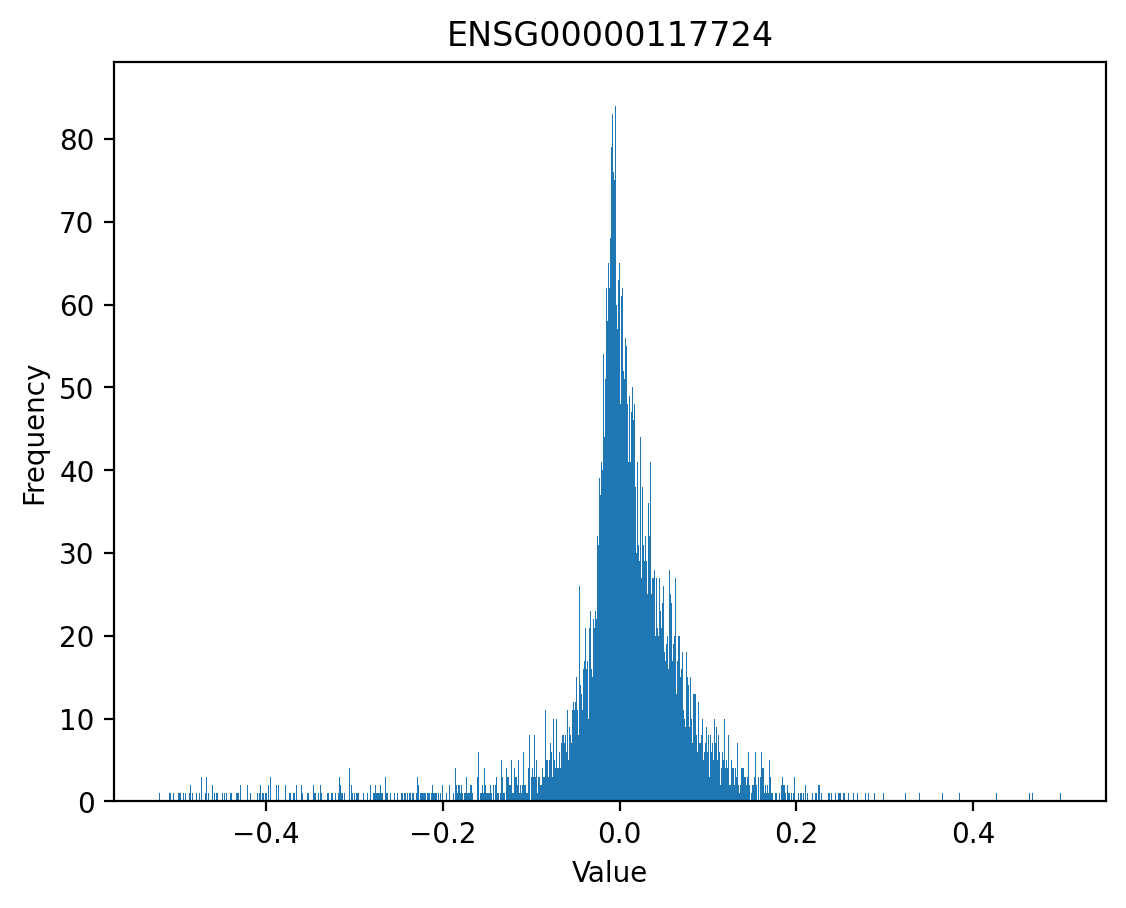

{'mean': 0.020094886564591453, 'median': -0.005898890241815208, 'minimum': -0.1869483625614869, 'maximum': 0.5018360419940202, 'q1': -0.03366495561284697, 'q3': 0.03865989991911592}


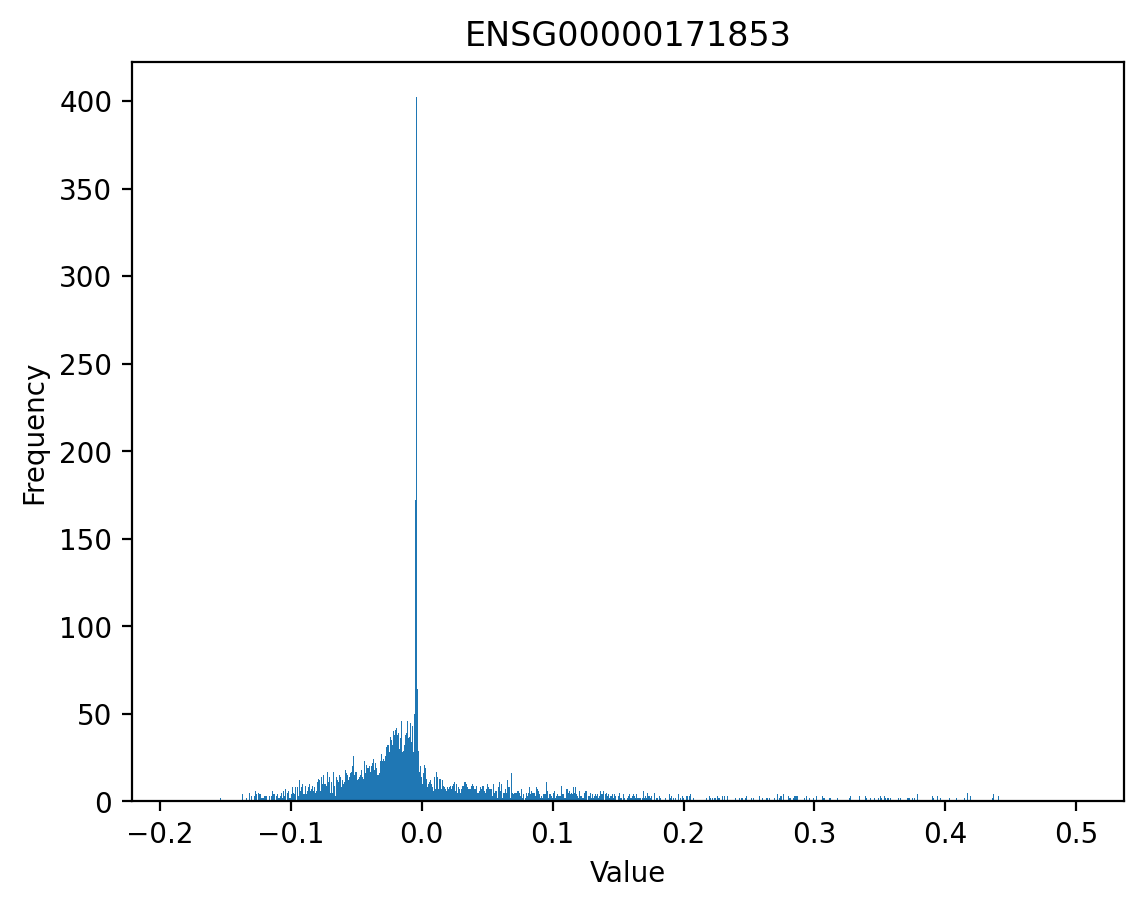

{'mean': -0.027029690715846363, 'median': -0.020606840475182086, 'minimum': -0.2644731244631044, 'maximum': 0.4747824507436258, 'q1': -0.06163065018960191, 'q3': 0.004924883348254636}


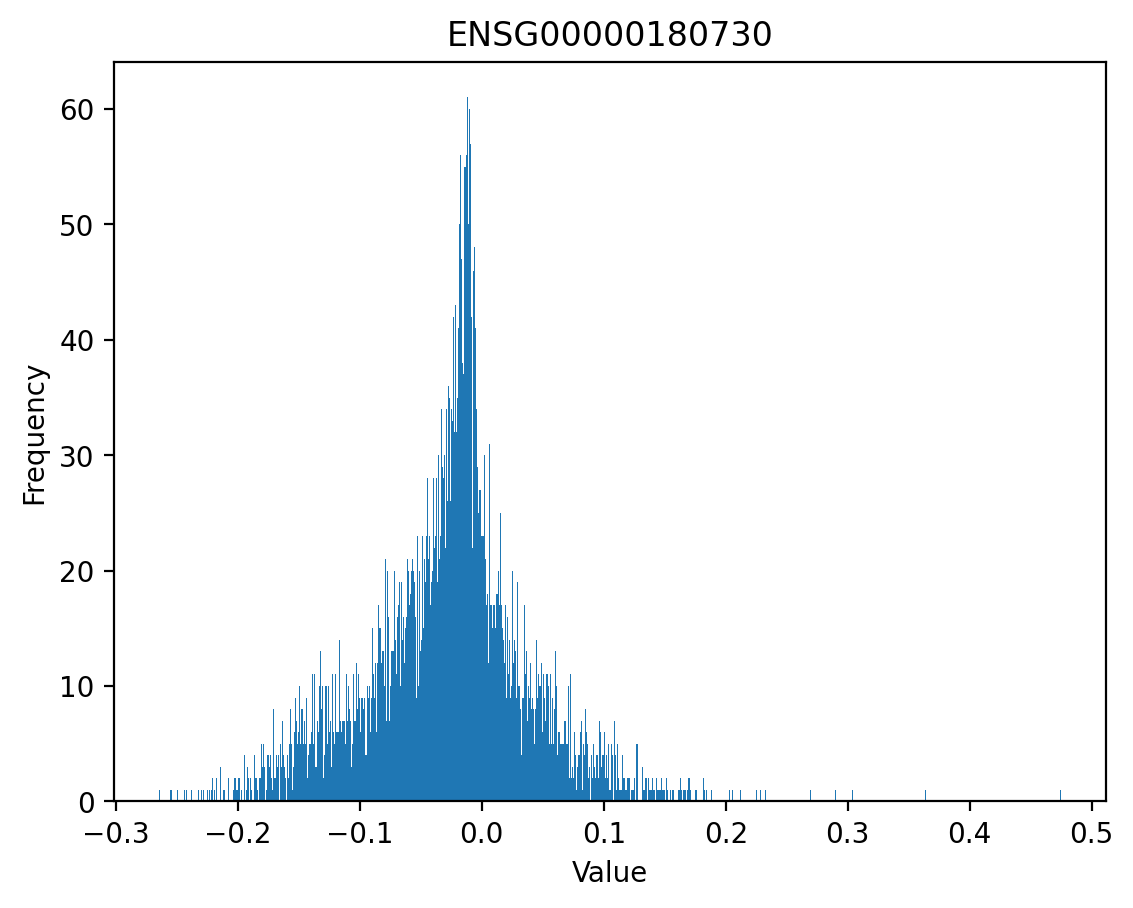

{'mean': -0.01409076005018665, 'median': -0.00701936003908897, 'minimum': -0.4369832330752177, 'maximum': 0.5233482177668853, 'q1': -0.042085071093807665, 'q3': 0.025758731029570183}


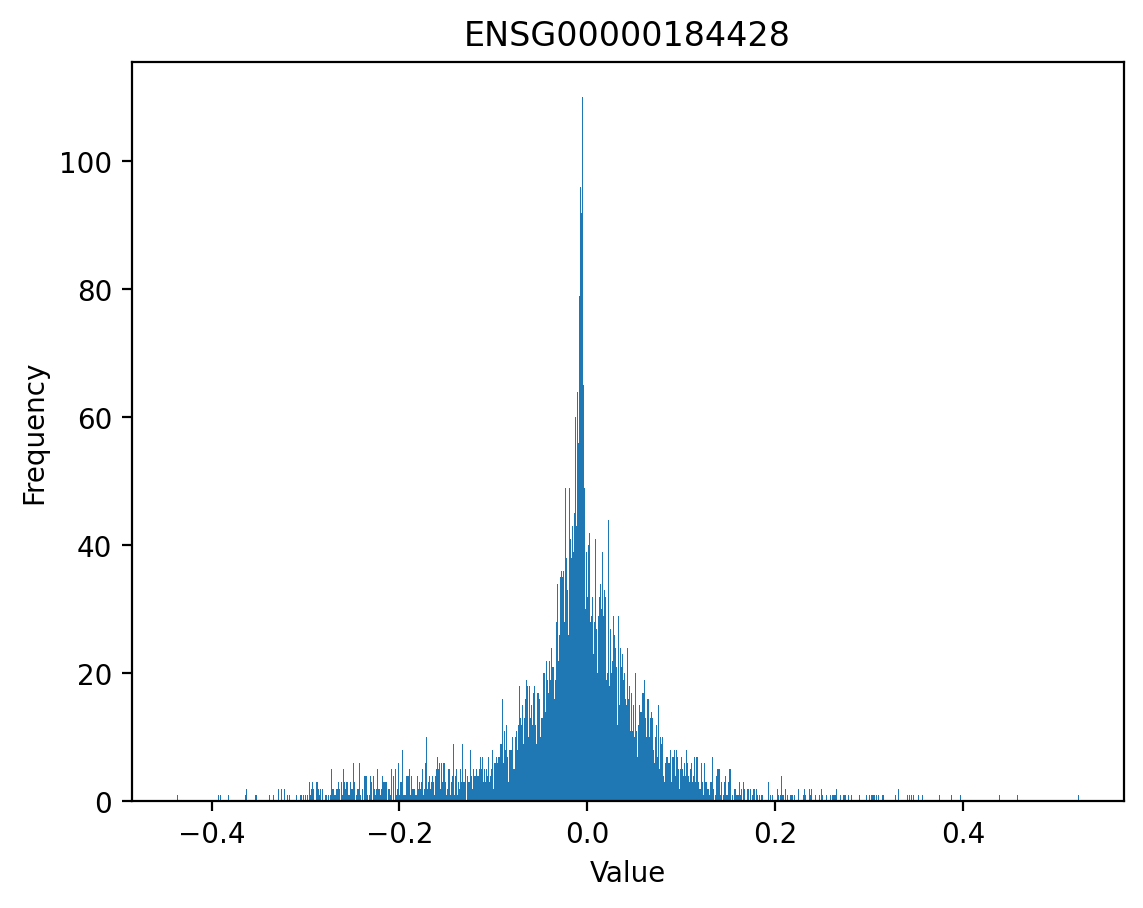

{'mean': -0.0659560101027388, 'median': -0.06347865286362854, 'minimum': -0.4821908594547957, 'maximum': 0.21632240243055753, 'q1': -0.10709060268727029, 'q3': -0.024248362922380744}


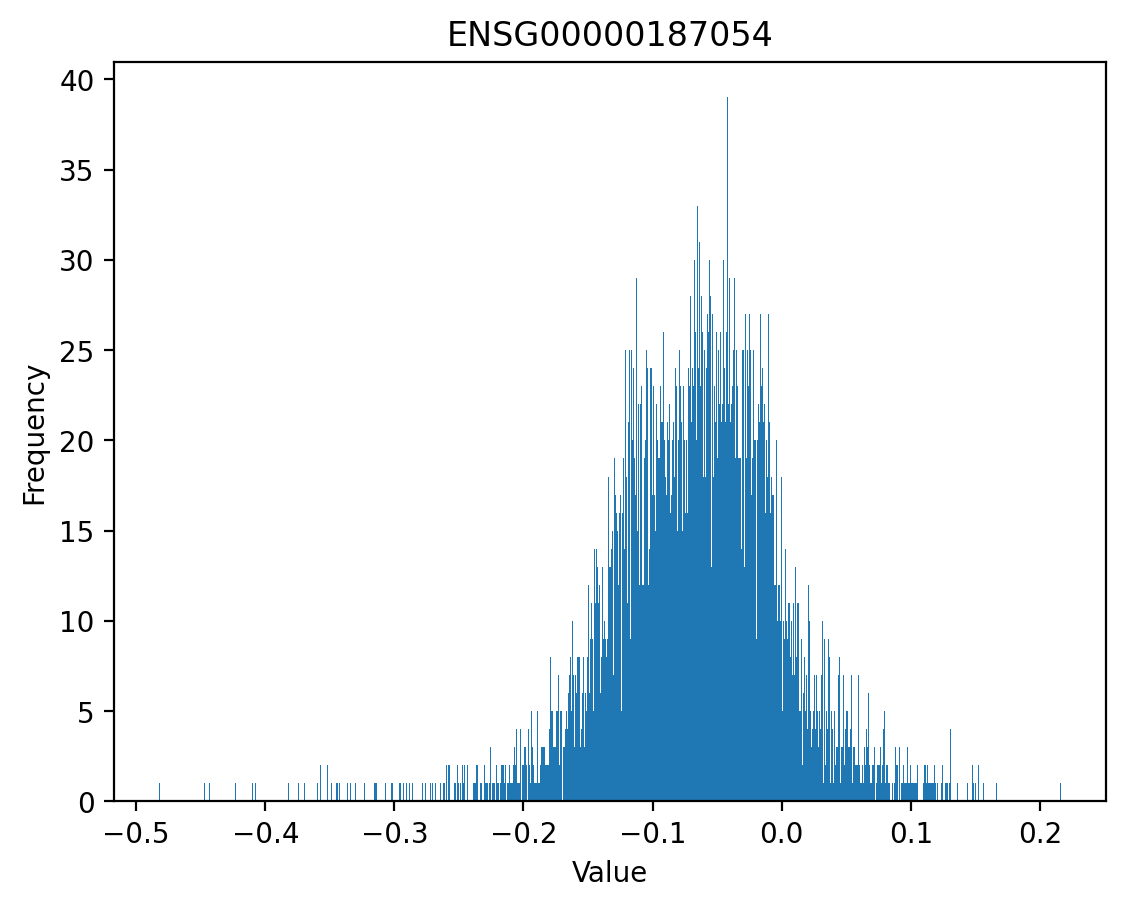

In [26]:
for gene in corr_dict.keys():
    print(get_summary(corr_dict[gene]))
    plot_hist(corr_dict[gene], 1000, title=gene)

This is pretty bad. But we'll still plot the brain CAGE tracks, in case the root of our problems is bin indexing.

In [20]:
def plot_CAGE_tracks(gene):
    gene_annot = annot_df.loc[gene]
    start = gene_annot['transcription_start_site'] - 57344
    end = gene_annot['transcription_start_site'] + 57344
    target_interval = kipoiseq.Interval(f"chr{gene_annot['chromosome_name']}", start, end)
    tracks = {"Centered at TSS": tss_predictions[gene][:, 4980],
              "Queried from reference": predicted_reference_epigenome[gene][:,4980]}
    plot_tracks(tracks, target_interval)

In [10]:
annot_df.head()

,external_gene_name,chromosome_name,transcription_start_site
ensembl_gene_id,,,
ENSG00000142611,PRDM16,1,3069203
ENSG00000157911,PEX10,1,2412564
ENSG00000142655,PEX14,1,10474950
ENSG00000149527,PLCH2,1,2476289
ENSG00000171621,SPSB1,1,9292894


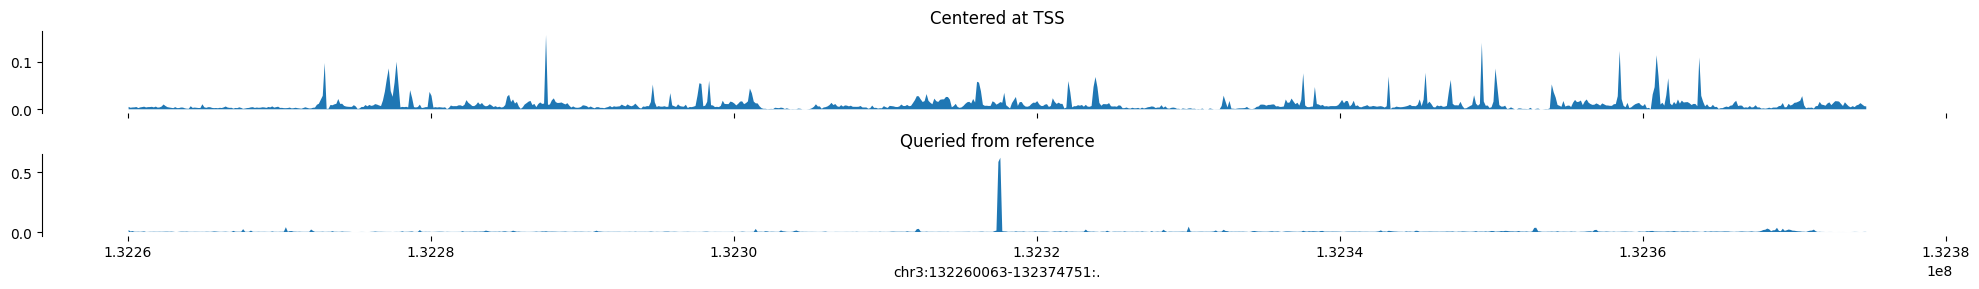

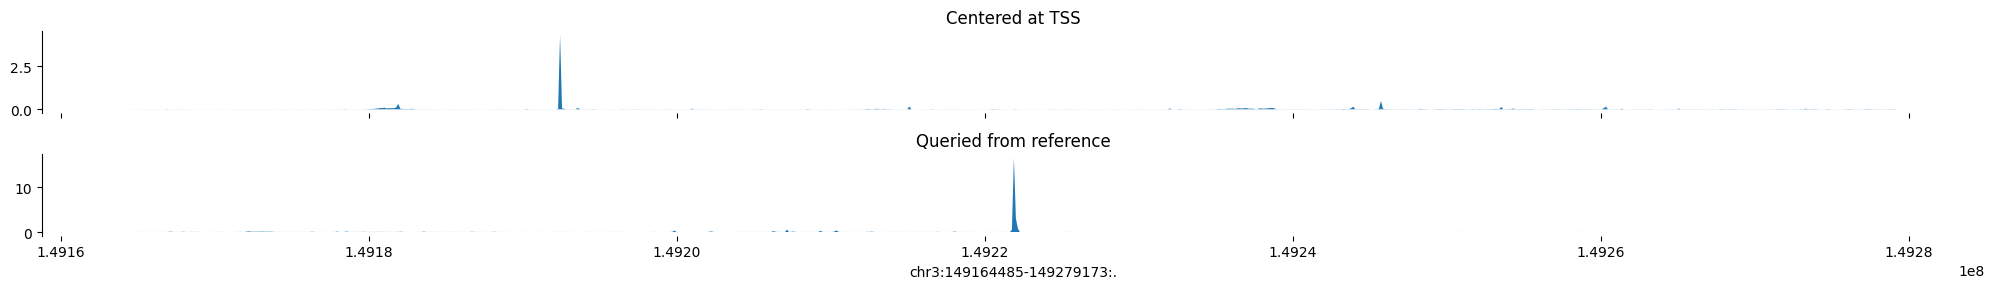

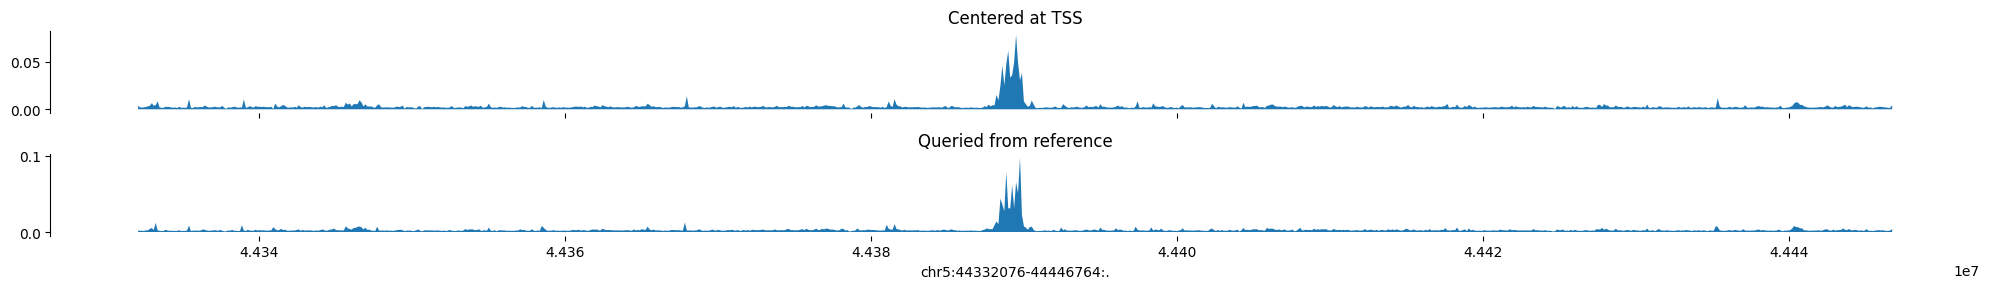

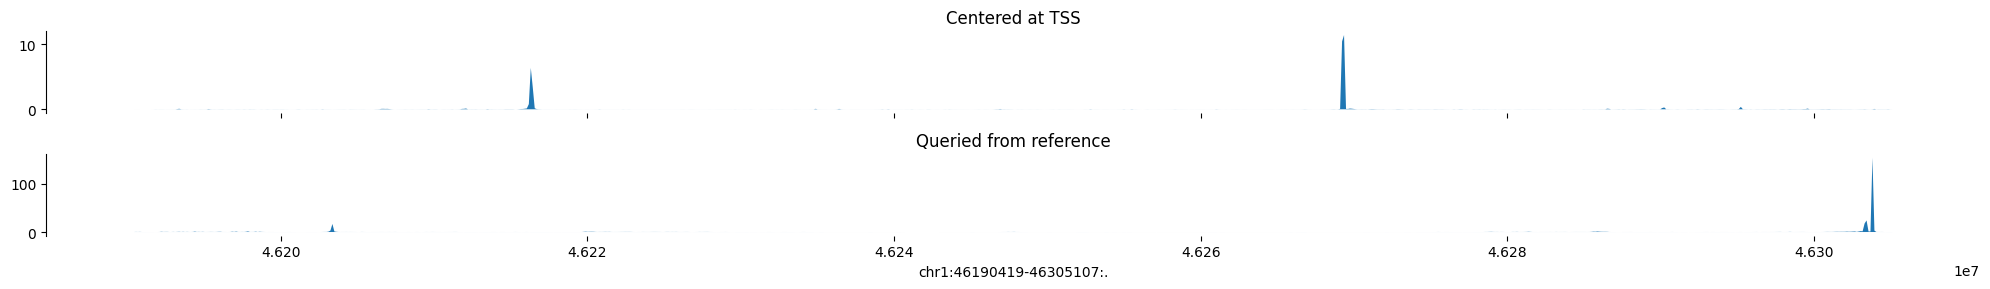

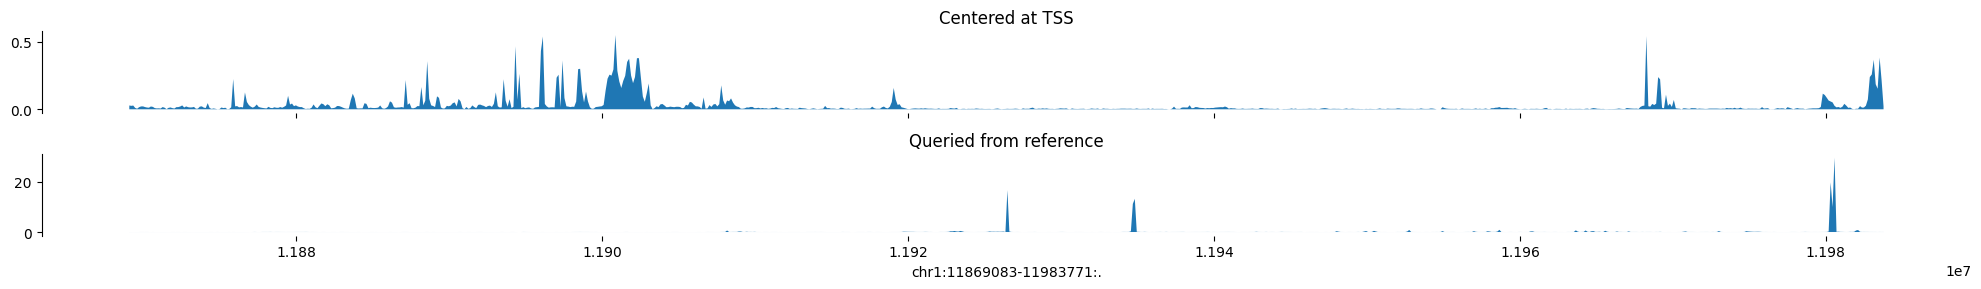

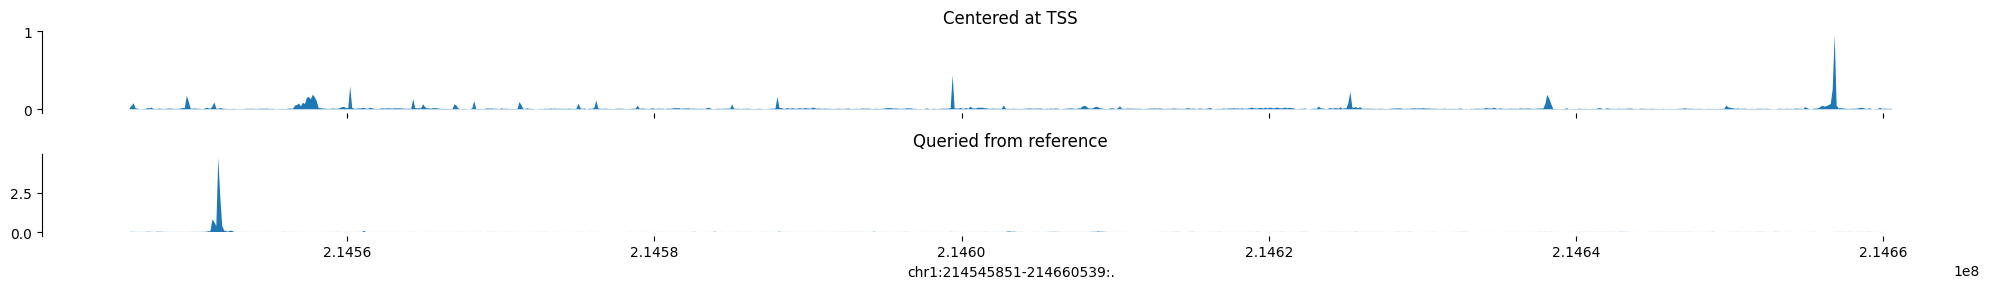

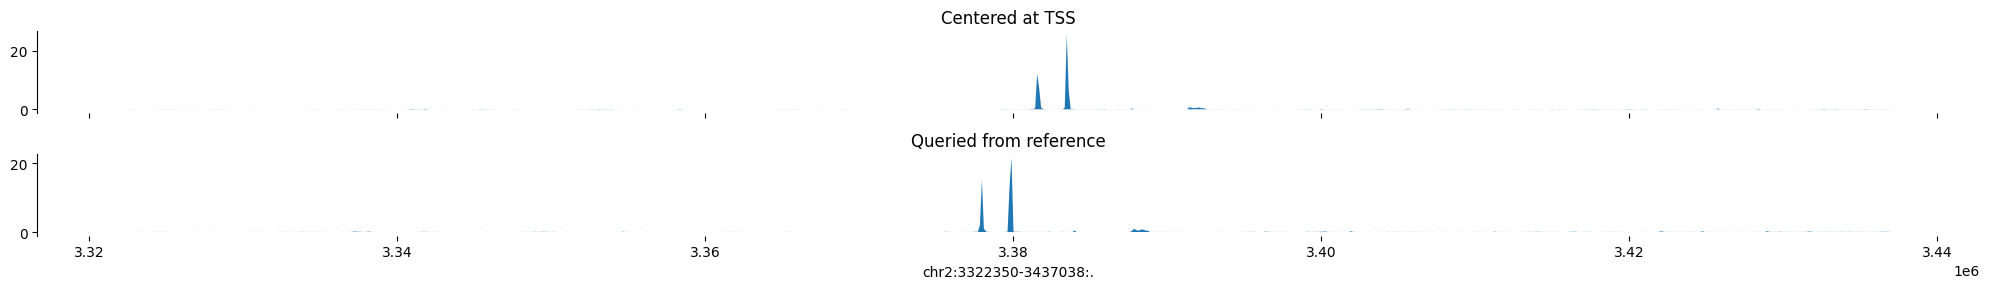

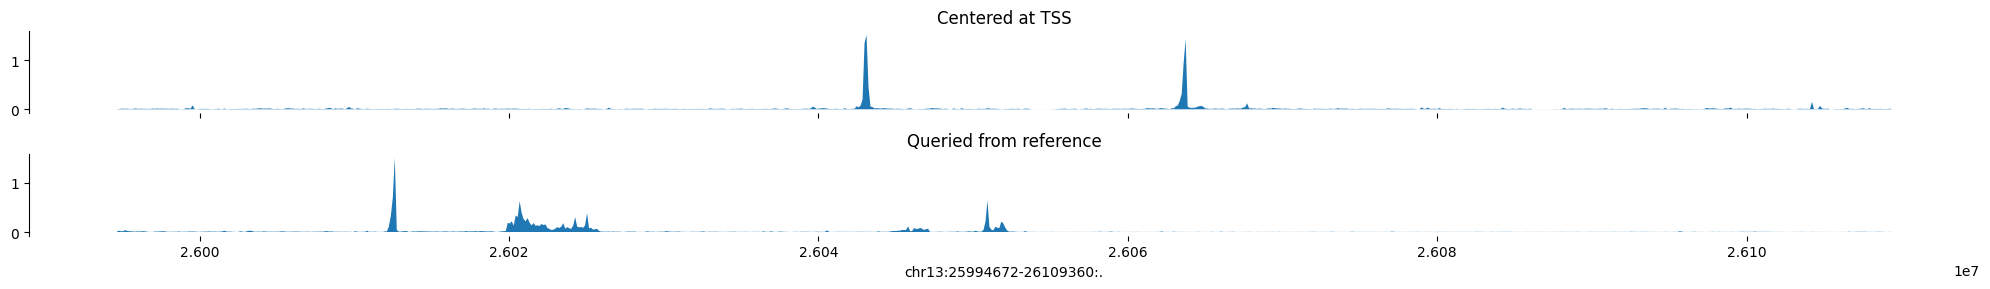

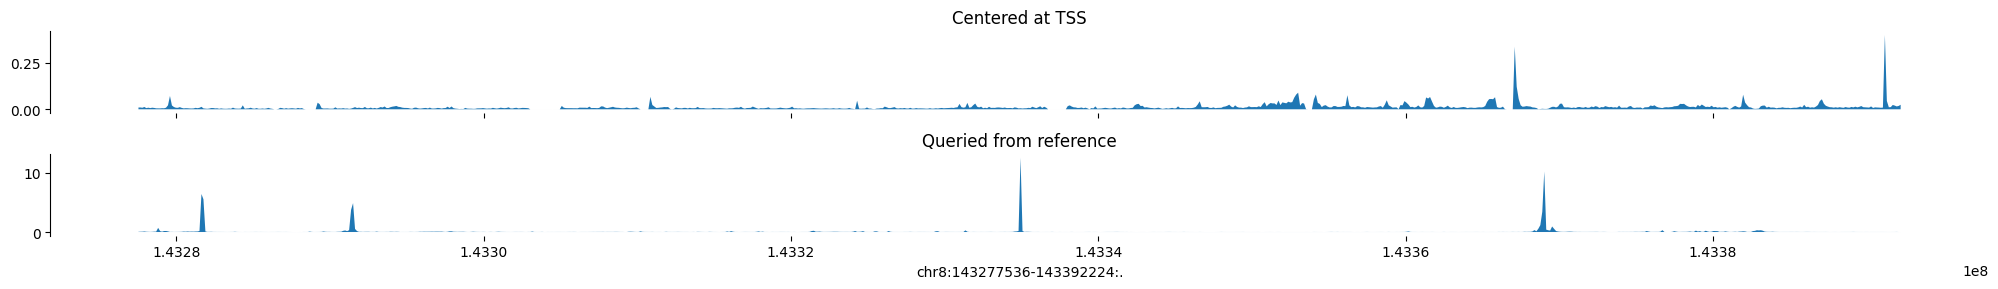

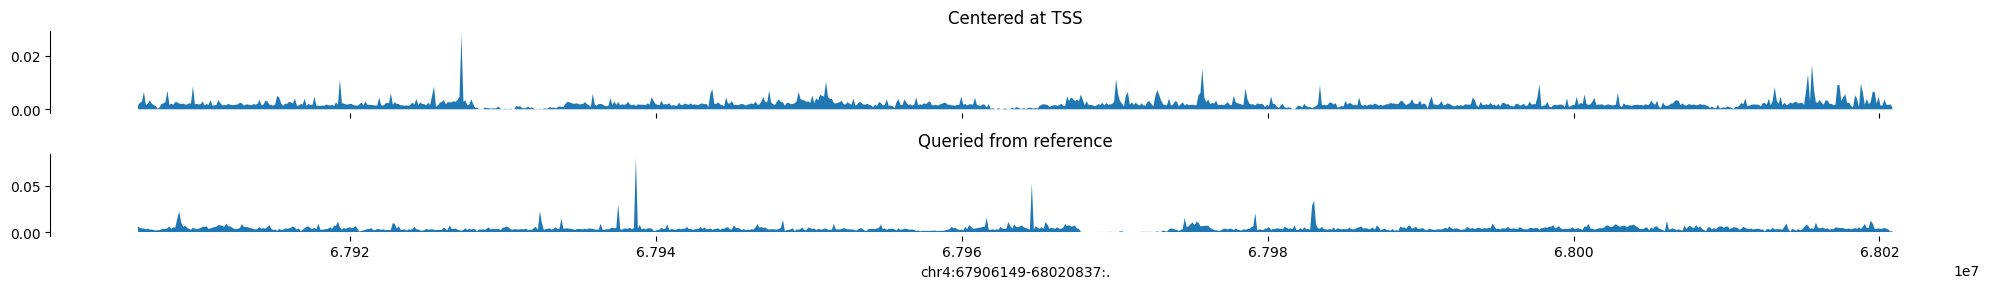

In [22]:
for gene in tss_predictions.keys():
    plot_CAGE_tracks(gene)